# UPSET DETECTION

The most important part of training an effective March Madness model is predicting upsets. The tendency for the model is just to spit out the higher seed because obviously the higher seed wins more often ($73\%$ since 2003) of games. But $27\%$ is not an insignificant percentage. The purpose of this notebook is to analyze trends in tournament upsets and generate a model to predict when there will be an upset.

In [ ]:
from concurrent.futures import ProcessPoolExecutor
import sys
import os
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
sys.path.append("/Users/atticussoane/Desktop/atticus_tools/")
from recursive_selection import FeatureSelector
from dataclasses import dataclass, field

# Historical Seed Analysis

In [43]:
historical_results = pd.read_csv("./MDataFiles_Stage1/MNCAATourneyCompactResults.csv")
historical_seeds = pd.read_csv("./MDataFiles_Stage1/MNCAATourneySeeds.csv")

In [46]:
historical_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [45]:
historical_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [47]:
historical_seeds.Seed.unique()

array(['W01', 'W02', 'W03', 'W04', 'W05', 'W06', 'W07', 'W08', 'W09',
       'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'X01', 'X02',
       'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'Y01', 'Y02', 'Y03', 'Y04',
       'Y05', 'Y06', 'Y07', 'Y08', 'Y09', 'Y10', 'Y11', 'Y12', 'Y13',
       'Y14', 'Y15', 'Y16', 'Z01', 'Z02', 'Z03', 'Z04', 'Z05', 'Z06',
       'Z07', 'Z08', 'Z09', 'Z10', 'Z11', 'Z12', 'Z13', 'Z14', 'Z15',
       'Z16', 'Y16a', 'Y16b', 'W16a', 'W16b', 'X16a', 'X16b', 'Z16a',
       'Z16b', 'W12a', 'W12b', 'Z11a', 'Z11b', 'X12a', 'X12b', 'Z14a',
       'Z14b', 'Y11a', 'Y11b', 'Z13a', 'Z13b', 'Y12a', 'Y12b', 'W11a',
       'W11b', 'X11a', 'X11b'], dtype=object)

In [48]:
historical_results = historical_results.merge(historical_seeds, how = "left",
                                             left_on = ["Season", "WTeamID"],
                                             right_on = ["Season", "TeamID"])
historical_results = historical_results.drop(columns = ["TeamID"]).rename(columns = {"Seed" : "WSeed"})
historical_results = historical_results.merge(historical_seeds, how = "left",
                                             left_on = ["Season", "LTeamID"],
                                             right_on = ["Season", "TeamID"])
historical_results = historical_results.drop(columns = ["TeamID"]).rename(columns = {"Seed" : "LSeed"})


In [51]:
historical_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed
0,1985,136,1116,63,1234,54,N,0,X09,X08
1,1985,136,1120,59,1345,58,N,0,Z11,Z06
2,1985,136,1207,68,1250,43,N,0,W01,W16
3,1985,136,1229,58,1425,55,N,0,Y09,Y08
4,1985,136,1242,49,1325,38,N,0,Z03,Z14


In [53]:
def prep_seeds(s):
    s = s[1:]
    s = s.replace("a", "", 1)
    s = s.replace("b", "", 1)
    return(s)

historical_results["WseedN"] = historical_results.WSeed.map(lambda x: prep_seeds(x)).astype("int32")
historical_results["LseedN"] = historical_results.LSeed.map(lambda x: prep_seeds(x)).astype("int32")

historical_results = historical_results.drop(columns = ["WSeed", "LSeed"])
historical_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WseedN,LseedN
0,1985,136,1116,63,1234,54,N,0,9,8
1,1985,136,1120,59,1345,58,N,0,11,6
2,1985,136,1207,68,1250,43,N,0,1,16
3,1985,136,1229,58,1425,55,N,0,9,8
4,1985,136,1242,49,1325,38,N,0,3,14


In [56]:
round_map = {
    134 : 0,
    135 : 0,
    136 : 1,
    137 : 1,
    138 : 2,
    139 : 2,
    143 : 3,
    144 : 3,
    145 : 4,
    146 : 4,
    152 : 5,
    154 : 6
    
}

historical_results["tourney_round"] = historical_results.DayNum.map(round_map)

upsets = []
for k in range(len(historical_results)):
    if historical_results.iloc[k]["WseedN"] > historical_results.iloc[k]["LseedN"]:
        upsets.append(1)
    else:
        upsets.append(0)
historical_results["is_upset"] = pd.Series(upsets)

In [58]:
historical_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WseedN,LseedN,tourney_round,is_upset
0,1985,136,1116,63,1234,54,N,0,9,8,1,1
1,1985,136,1120,59,1345,58,N,0,11,6,1,1
2,1985,136,1207,68,1250,43,N,0,1,16,1,0
3,1985,136,1229,58,1425,55,N,0,9,8,1,1
4,1985,136,1242,49,1325,38,N,0,3,14,1,0


In [166]:
def upset_analysis_by_round(df):
    
    def handshake_problem(l):
        if type(l) == set:
            l = list(l)
        all_combos = []
        l = sorted(l)
        for i in range(len(l)- 1):
            j = i
            all_combos.append((l[i], l[j]))
            while j < len(l) -1 :
                j += 1
                all_combos.append((l[i], l[j]))
        return(all_combos)
    by_round = {}
    all_rounds = [1, 2, 3, 4, 5, 6]
    for rnd in all_rounds:
        
        all_seeds = set(list(df[df.tourney_round == rnd].WseedN.unique()) +\
        list(df[df.tourney_round == rnd].LseedN.unique()))
        
        possible_matchups = handshake_problem(all_seeds)
        
        matchup_results = []
        
        round_games = df[df.tourney_round == rnd]
        
        for pair in possible_matchups:
            all_matchups = round_games[((round_games.WseedN == pair[0]) & (round_games.LseedN == pair[1])) |
                                      ((round_games.WseedN == pair[1]) & (round_games.LseedN == pair[0]))]
            if len(all_matchups) != 0:
                d = {}
                n_games = len(all_matchups)
                n_upsets = len(all_matchups[all_matchups.is_upset == 1])
                d["matchup"] = "{}v{}".format(pair[0], pair[1])
                d["total_upsets"] = n_upsets
                d["total_matchups"] = n_games
                d["upset_pct"] = n_upsets / n_games
                d["roundNum"] = rnd
                matchup_results.append(d)
            else:
                continue

        round_df = pd.DataFrame(matchup_results).sort_values(by = ["total_matchups",
                                                                         "upset_pct"], ascending = False)
        by_round[rnd] = round_df
    return(by_round)
        
all_rounds = upset_analysis_by_round(historical_results)

In [231]:
def plot_round(df, rnd):
    fig, ax1 = plt.subplots(figsize = (10, 10))
    pos = np.arange(len(df.matchup))
    rects = ax1.barh(pos, df.upset_pct,
                     align='center',
                     height=0.5,
                    tick_label = df.total_matchups)

    ax1.set_title("Round {} Seeds Analysis".format(str(rnd)), weight = "bold")
    ax1.xaxis.set_major_locator(plt.MaxNLocator(11))
    ax1.set_xlim([0, 1.0])
    ax1.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
    ax1.set_ylabel("Total Matchups Since 1985")
    ax1.axvline(0.5, color='grey', alpha=0.75)
    ax2 = ax1.twinx()
    ax2.set_yticks(pos)
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_yticklabels(df.matchup, weight = "bold")
    ax2.set_ylabel('Matchup')

    r_labels = []
    for rect in rects:
        width = rect.get_width()
        lbl = "{}%".format(str(round(width*100, 2)))
        if width < 0.85:
            xshift = 5
            c = "black"
            align = "left"
        else:
            xshift = -5
            c = "white"
            align = "right"

        yshift = rect.get_y() + rect.get_height() / 2

        label = ax1.annotate(lbl, xy=(width, yshift), xytext=(xshift, 0),
                            textcoords="offset points",
                            ha=align, va='center',
                            color=c, weight='bold', clip_on=True)
        r_labels.append(label)
    return {'fig': fig,
            'ax': ax1,
            'ax_right': ax2,
            'bars': rects,
            'perc_labels': r_labels}
 

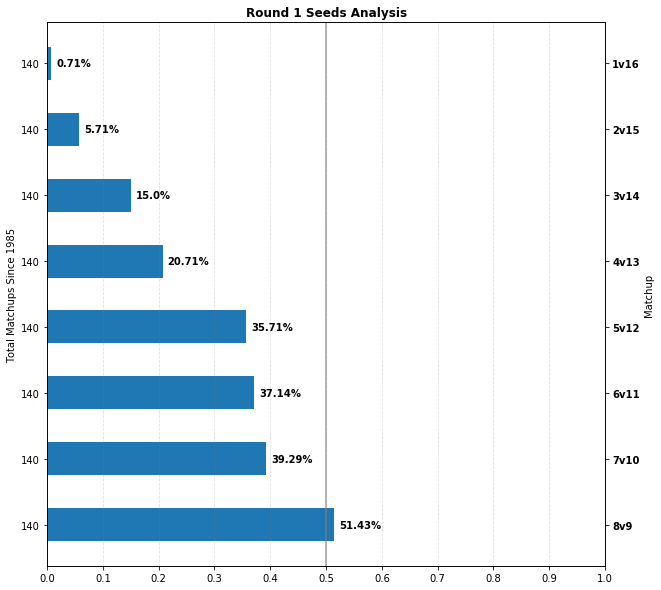

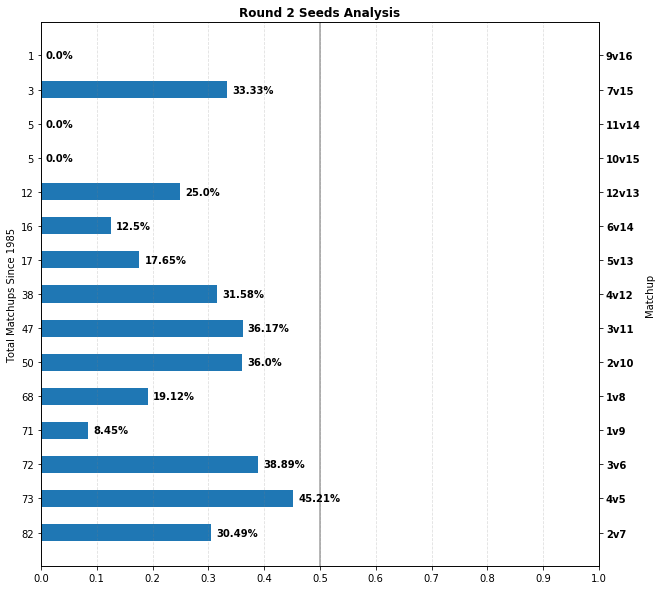

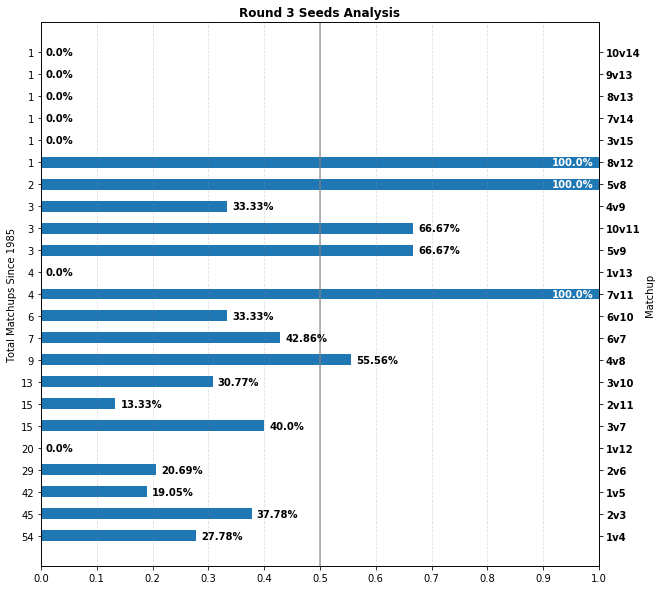

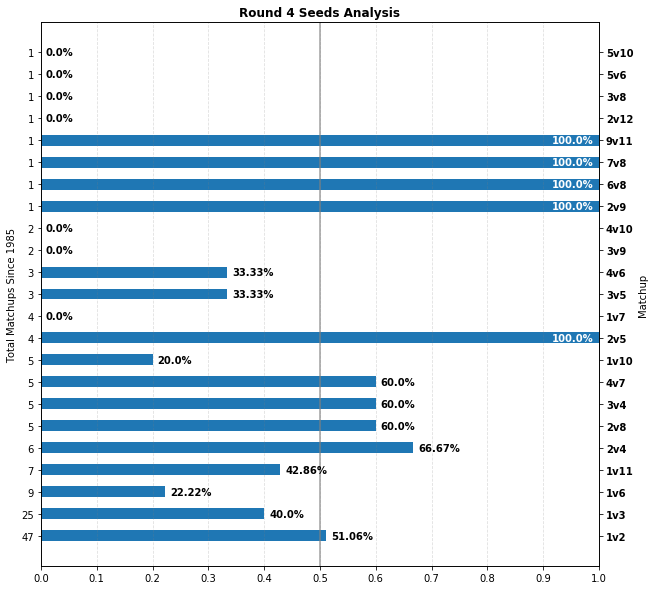

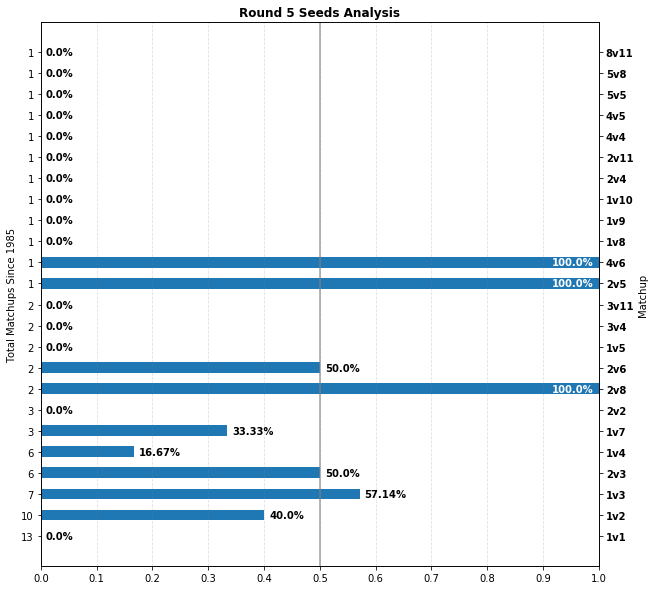

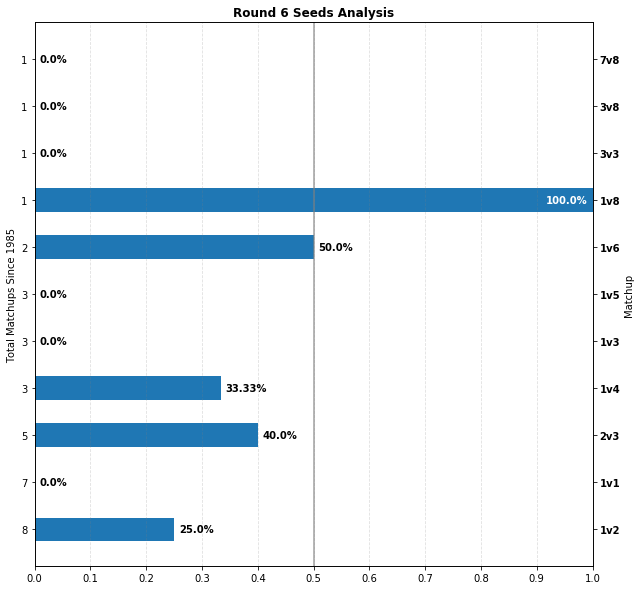

In [234]:
for rnd in all_rounds:
    plot_round(all_rounds[rnd], rnd);

# UPSET PREDICTION

# APPEND RANKINGS, CREATE TARGET VARIABLE

All data used in this notebook was created from the Google Cloud / Kaggle data available via the Kaggle March Madness 2020 Tournament contest. (see: __00DataSetCreation-FeatureEngineering.ipynb__)

In [2]:
df = pd.read_csv("./engineered_data/tournament_modeling2003-2019.csv.gz", compression = "gzip")

In [4]:
pd.set_option("max.columns", 150)
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WseedN,WDRB_DIF,WORB_DIF,WPPG,WPPP,WTRB_DIF,Wast_TO,We_fg,Wfg,Wfree_throw_pct,Wopp_PPG,Wopp_PPP,Wopp_ast_TO,Wopp_efg,Wopp_fg,Wopp_three_point_pct,Wopp_trueshooting,Wthree_point_pct,Wtotal_point_differential,Wtrue_shooting,Wacc,Wbig_east,Wbig_ten,Wbig_twelve,Wsec,Wpac12,WMOR,WAP_top10,WAP_top25,LseedN,LDRB_DIF,LORB_DIF,LPPG,LPPP,LTRB_DIF,Last_TO,Le_fg,Lfg,Lfree_throw_pct,Lopp_PPG,Lopp_PPP,Lopp_ast_TO,Lopp_efg,Lopp_fg,Lopp_three_point_pct,Lopp_trueshooting,Lthree_point_pct,Ltotal_point_differential,Ltrue_shooting,Lacc,Lbig_east,Lbig_ten,Lbig_twelve,Lsec,Lpac12,LMOR,LAP_top10,LAP_top25
0,2003,134,1421,92,1411,84,16,10,-42,71.206897,0.866162,-32,0.804255,0.486339,0.429265,0.762768,78.448276,0.937078,1.236559,0.518382,0.455882,0.367110,0.553323,0.360153,-210,0.539424,0,0,0,0,0,0,277.0,0,0,16,58,37,72.800000,0.878704,95,0.932166,0.501206,0.447527,0.619952,70.833333,0.853660,0.960465,0.487307,0.424945,0.325180,0.515957,0.320721,59,0.538334,0,0,0,0,0,0,293.0,0,0
1,2003,136,1112,80,1436,51,1,122,58,85.214286,0.931304,180,1.193237,0.514946,0.461413,0.701429,70.250000,0.786410,0.917373,0.456378,0.407510,0.316637,0.484664,0.350534,419,0.555400,0,0,0,0,0,1,4.0,1,0,16,112,98,67.793103,0.863235,210,1.009804,0.491667,0.444444,0.657848,63.137931,0.841808,1.021220,0.477458,0.413275,0.329582,0.509154,0.340757,135,0.525815,0,0,0,0,0,0,187.0,0,0
2,2003,136,1113,84,1272,71,10,80,78,75.965517,0.921603,158,1.110837,0.513333,0.478182,0.669737,69.172414,0.862499,0.906667,0.494424,0.445477,0.342733,0.534705,0.317808,197,0.555080,0,0,0,0,0,1,22.0,0,0,7,69,50,74.517241,0.888511,119,1.205000,0.496264,0.437931,0.653614,65.827586,0.802290,0.883295,0.453218,0.402265,0.322034,0.491392,0.348797,252,0.531700,0,0,0,0,0,0,23.0,0,1
3,2003,136,1141,79,1166,73,11,127,-48,79.344828,0.967538,79,0.856333,0.570026,0.505236,0.765753,73.241379,0.875414,0.733906,0.497619,0.454762,0.357320,0.541759,0.380769,177,0.622161,0,0,0,0,0,0,50.0,0,0,6,60,-6,79.242424,0.995114,54,1.258503,0.568829,0.499473,0.692890,64.333333,0.806783,0.724689,0.475630,0.431544,0.341102,0.513189,0.389053,492,0.597895,0,0,0,0,0,0,33.0,0,1
4,2003,136,1143,76,1301,74,8,40,2,74.482759,0.914077,42,1.128954,0.520258,0.465649,0.685512,69.758621,0.856971,1.073903,0.492082,0.431672,0.331190,0.524735,0.376518,137,0.553267,0,0,0,0,0,1,43.0,0,0,9,18,-24,72.400000,0.945927,-6,1.032864,0.530937,0.456250,0.770358,68.000000,0.882032,0.858770,0.494981,0.441029,0.337255,0.544337,0.354074,132,0.580699,1,0,0,0,0,0,31.0,0,0


In [5]:
final_rankings = pd.read_csv("./engineered_data/finalrankings.csv.gz", compression = "gzip")

In [6]:
final_rankings.head()

,7OT,ACU,ADE,AP,ARG,AUS,AWS,BBT,BCM,BD,BIH,BKM,BLS,BNM,BNT,BOB,BPI,BRZ,BUR,BWE,CJB,CMV,CNG,COL,COX,CPA,CPR,CRO,CRW,D1A,DAV,DC,DC2,DCI,DDB,DES,DII,DOK,DOL,DUN,DWH,EBP,ECK,ENT,ERD,ESR,FAS,FMG,FSH,GRN,GRS,HAS,HAT,HER,HKB,HKS,HOL,HRN,IMS,INC,INP,ISR,JCI,JEN,JJK,JNG,JON,JRT,KBM,KEL,KLK,KMV,KOS,KPI,KPK,...,MSX,MUZ,MvG,NET,NOL,NOR,OCT,OMY,PEQ,PGH,PH,PIG,PIR,PKL,PMC,POM,PPR,PRR,PTS,REI,REN,REW,RIS,RM,ROG,ROH,RPI,RSE,RSL,RT,RTB,RTH,RTP,RTR,SAG,SAP,SAU,SCR,SE,SEL,SFX,SGR,SIM,SMN,SMS,SP,SPR,SPW,STF,STH,STM,STR,STS,TBD,TMR,TPR,TRK,TRP,TRX,TSR,TW,UCS,UPS,USA,WIL,WLK,WMR,WMV,WOB,WOL,WTE,YAG,ZAM,season,teamID
0,NaN,NaN,NaN,NaN,141.0,NaN,NaN,NaN,NaN,NaN,172.0,NaN,NaN,NaN,NaN,146.0,NaN,161.0,NaN,NaN,NaN,NaN,NaN,162.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.0,97.0,149.0,NaN,156.0,155.0,147.0,NaN,NaN,NaN,NaN,161.0,166.0,NaN,NaN,148.0,NaN,NaN,185.0,NaN,198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.0,NaN,NaN,NaN,NaN,146.0,NaN,NaN,149.0,NaN,154.0,NaN,162.0,155.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,146.0,NaN,NaN,NaN,NaN,NaN,165.0,NaN,NaN,155.0,157.0,156.0,NaN,NaN,2003,1102
1,NaN,NaN,NaN,NaN,180.0,NaN,NaN,NaN,NaN,NaN,177.0,NaN,NaN,NaN,NaN,179.0,NaN,174.0,NaN,NaN,NaN,NaN,NaN,172.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174.0,165.0,168.0,NaN,194.0,176.0,128.0,NaN,NaN,NaN,NaN,168.0,172.0,NaN,NaN,176.0,NaN,NaN,167.0,NaN,152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.0,NaN,NaN,NaN,NaN,168.0,NaN,NaN,172.0,NaN,170.0,NaN,167.0,169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.0,NaN,NaN,NaN,NaN,NaN,172.0,NaN,NaN,177.0,171.0,161.0,NaN,NaN,2003,1103
2,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,35.0,NaN,34.0,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,43.0,33.0,NaN,51.0,34.0,36.0,NaN,NaN,NaN,NaN,40.0,50.0,NaN,NaN,37.0,NaN,NaN,60.0,NaN,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN,NaN,31.0,NaN,NaN,37.0,NaN,32.0,NaN,41.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,36.0,NaN,NaN,37.0,37.0,28.0,NaN,NaN,2003,1104
3,NaN,NaN,NaN,NaN,307.0,NaN,NaN,NaN,NaN,NaN,312.0,NaN,NaN,NaN,NaN,313.0,NaN,305.0,NaN,NaN,NaN,NaN,NaN,310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.0,306.0,315.0,NaN,314.0,309.0,309.0,NaN,NaN,NaN,NaN,313.0,298.0,NaN,NaN,307.0,NaN,NaN,297.0,NaN,310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313.0,NaN,NaN,NaN,NaN,312.0,NaN,NaN,312.0,NaN,312.0,NaN,314.0,312.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,289.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.0,NaN,NaN,NaN,NaN,NaN,310.0,NaN,NaN,312.0,311.0,299.0,NaN,NaN,2003,1105
4,NaN,NaN,NaN,NaN,252.0,NaN,NaN,NaN,NaN,NaN,269.0,NaN,NaN,NaN,NaN,265.0,NaN,219.0,NaN,NaN,NaN,NaN,NaN,256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266.0,305.0,269.0,NaN,245.0,259.0,283.0,NaN,NaN,NaN,NaN,279.0,227.0,NaN,NaN,245.0,NaN,NaN,198.0,NaN,272.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,274.0,NaN,NaN,268.0,NaN,264.0,NaN,276.0,267.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,294.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,279.0,NaN,NaN,NaN,NaN,NaN,254.0,NaN,NaN,265.0,270.0,256.0,NaN,NaN,2003,1106


In [7]:
with open("./models/regular_season_ranking_features.json", "r+") as f:
    rating_cols = json.load(f)

In [9]:
ratings = ["COL", "DOL", "MOR", "POM", "RTH", "SAG", "WLK", "WOL"]

In [14]:
append_ratings = []
for k in range(len(df)):
    d = {}
    winner = df.iloc[k].WTeamID
    loser = df.iloc[k].LTeamID
    season = df.iloc[k].Season
    d["WTeamID"] = winner
    d["LTeamID"] = loser
    d["Season"] = season
    for col in ratings:
        d["W"+col] = final_rankings[(final_rankings.teamID == winner) &
                           (final_rankings.season == season)][col].values[0]
        d["L"+col] = final_rankings[(final_rankings.teamID == loser) &
                                   (final_rankings.season == season)][col].values[0]
    append_ratings.append(d)

In [16]:
eos_ratings = pd.DataFrame(append_ratings)
df = df.merge(eos_ratings, how = "left", left_on = ["WTeamID", "LTeamID", "Season"],
             right_on = ["WTeamID", "LTeamID", "Season"])

In [18]:
df = df.drop(columns = ["WMOR_y", "LMOR_y"]).rename(columns = {"WMOR_x" : "WMOR",
                                                              "LMOR_x" : "LMOR"})

In [20]:
#create upset variable
upset = []
for k in range(len(df)):
    if df.iloc[k]["WseedN"] > df.iloc[k]["LseedN"]:
        upset.append(1)
    else:
        upset.append(0)
upset = pd.Series(upset).rename("is_upset")

In [22]:
upset.value_counts()

0    812
1    303
Name: is_upset, dtype: int64

In [24]:
df = pd.concat([df, upset], axis = 1)

# ADD ROUND NUMBER (I.E.- ROUND OF 64, ROUND OF 32, ROUND OF 16, ETC.)

In [31]:
for season in df.Season.unique():
    print("The tournament round dates for season {} are:".format(str(season)))
    print(df[df.Season == season].DayNum.unique())

The tournament round dates for season 2003 are:
[134 136 137 138 139 143 144 145 146 152 154]
The tournament round dates for season 2004 are:
[134 136 137 138 139 143 144 145 146 152 154]
The tournament round dates for season 2005 are:
[134 136 137 138 139 143 144 145 146 152 154]
The tournament round dates for season 2006 are:
[134 136 137 138 139 143 144 145 146 152 154]
The tournament round dates for season 2007 are:
[134 136 137 138 139 143 144 145 146 152 154]
The tournament round dates for season 2008 are:
[134 136 137 138 139 143 144 145 146 152 154]
The tournament round dates for season 2009 are:
[134 136 137 138 139 143 144 145 146 152 154]
The tournament round dates for season 2010 are:
[134 136 137 138 139 143 144 145 146 152 154]
The tournament round dates for season 2011 are:
[134 135 136 137 138 139 143 144 145 146 152 154]
The tournament round dates for season 2012 are:
[134 135 136 137 138 139 143 144 145 146 152 154]
The tournament round dates for season 2013 are:
[134

# DATA EXPLORATION

In [36]:
from collections import Counter
seed_pairings = []
all_upsets = df[df.is_upset == 1]
for k in all_upsets.index:
    seed_pairings.append((df.iloc[k]["WseedN"], df.iloc[k]["LseedN"]))

In [40]:
upset_count = Counter(seed_pairings)
print("The ten most common upsets:")
print()
for i in range(10):
    print(upset_count.most_common()[i])

The ten most common upsets:

((9.0, 8.0), 33)
((11.0, 6.0), 29)
((12.0, 5.0), 27)
((10.0, 7.0), 26)
((5.0, 4.0), 18)
((2.0, 1.0), 16)
((7.0, 2.0), 15)
((13.0, 4.0), 14)
((3.0, 2.0), 14)
((11.0, 3.0), 10)


Unsurprisingly, the 8/9 first round matchup is the most common upset. It also would appear that there are more upsets in the first round because the top 4 all are first round matchups, however: there more games played in the first round so next we will look at upset percentage per round. From this brief glimpse: the two matchups standing out are the 11/3 and the 7/2... quick divergence:

In [41]:
two_seven_wins = len(df[(df.WseedN == 2) & (df.LseedN == 7)])
three_eleven_wins = len(df[(df.WseedN == 3) & (df.LseedN == 11)])
print("The two seed has beaten the seven seed {} times since 2003".format(str(two_seven_wins)))
print("The three seed has beaten the eleven seed {} times since 2003".format(str(three_eleven_wins)))

The two seed has beaten the seven seed 25 times since 2003
The three seed has beaten the eleven seed 19 times since 2003


Right off the bat, this is an interesting note.

Note: I will be excluding the round zero play-in games for two reasons:
1. Nobody cares.
2. They typically have the same seed so it's not technically an upset or not an upset. Obviously when St. Bonaventure beats UCLA, we would consider that an upset but for the purpose of this analysis we are looking solely at tournament upsets.

In [27]:
validation = df[df.Season > 2014].reset_index(drop = True)
training = df[df.Season <= 2014].reset_index(drop = True)

# DATAPREP

In [28]:
ytrain = training["is_upset"]
ytest = validation["is_upset"]

drop = ["Season", "DayNum", "WTeamID", "WScore", "LTeamID", "LScore", "WseedN", "LseedN", "is_upset"]
xtrain = training

drop = ["Season", "DayNum", "WTeamID", "WScore", "LTeamID", "LScore", "WseedN", "LseedN"]
training = training.drop(columns = drop)



,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WseedN,WDRB_DIF,WORB_DIF,WPPG,WPPP,WTRB_DIF,Wast_TO,We_fg,Wfg,Wfree_throw_pct,Wopp_PPG,Wopp_PPP,Wopp_ast_TO,Wopp_efg,Wopp_fg,Wopp_three_point_pct,Wopp_trueshooting,Wthree_point_pct,Wtotal_point_differential,Wtrue_shooting,Wacc,Wbig_east,Wbig_ten,Wbig_twelve,Wsec,Wpac12,WMOR,WAP_top10,WAP_top25,LseedN,LDRB_DIF,LORB_DIF,LPPG,LPPP,LTRB_DIF,Last_TO,Le_fg,Lfg,Lfree_throw_pct,Lopp_PPG,Lopp_PPP,Lopp_ast_TO,Lopp_efg,Lopp_fg,Lopp_three_point_pct,Lopp_trueshooting,Lthree_point_pct,Ltotal_point_differential,Ltrue_shooting,Lacc,Lbig_east,Lbig_ten,Lbig_twelve,Lsec,Lpac12,LMOR,LAP_top10,LAP_top25,WCOL,LCOL,WDOL,LDOL,WPOM,LPOM,WRTH,LRTH,WSAG,LSAG,WWLK,LWLK,WWOL,LWOL,is_upset
0,2003,134,1421,92,1411,84,16,10,-42,71.206897,0.866162,-32,0.804255,0.486339,0.429265,0.762768,78.448276,0.937078,1.236559,0.518382,0.455882,0.367110,0.553323,0.360153,-210,0.539424,0,0,0,0,0,0,277.0,0,0,16,58,37,72.800000,0.878704,95,0.932166,0.501206,0.447527,0.619952,70.833333,0.853660,0.960465,0.487307,0.424945,0.325180,0.515957,0.320721,59,0.538334,0,0,0,0,0,0,293.0,0,0,213.0,212.0,258.0,239.0,273.0,268.0,250.0,256.0,251.0,257.0,237.0,240.0,220.0,246.0,0
1,2003,136,1112,80,1436,51,1,122,58,85.214286,0.931304,180,1.193237,0.514946,0.461413,0.701429,70.250000,0.786410,0.917373,0.456378,0.407510,0.316637,0.484664,0.350534,419,0.555400,0,0,0,0,0,1,4.0,1,0,16,112,98,67.793103,0.863235,210,1.009804,0.491667,0.444444,0.657848,63.137931,0.841808,1.021220,0.477458,0.413275,0.329582,0.509154,0.340757,135,0.525815,0,0,0,0,0,0,187.0,0,0,2.0,144.0,2.0,156.0,3.0,144.0,2.0,182.0,2.0,158.0,2.0,153.0,2.0,177.0,0
2,2003,136,1113,84,1272,71,10,80,78,75.965517,0.921603,158,1.110837,0.513333,0.478182,0.669737,69.172414,0.862499,0.906667,0.494424,0.445477,0.342733,0.534705,0.317808,197,0.555080,0,0,0,0,0,1,22.0,0,0,7,69,50,74.517241,0.888511,119,1.205000,0.496264,0.437931,0.653614,65.827586,0.802290,0.883295,0.453218,0.402265,0.322034,0.491392,0.348797,252,0.531700,0,0,0,0,0,0,23.0,0,1,38.0,19.0,48.0,21.0,32.0,20.0,35.0,19.0,32.0,24.0,34.0,21.0,39.0,19.0,1
3,2003,136,1141,79,1166,73,11,127,-48,79.344828,0.967538,79,0.856333,0.570026,0.505236,0.765753,73.241379,0.875414,0.733906,0.497619,0.454762,0.357320,0.541759,0.380769,177,0.622161,0,0,0,0,0,0,50.0,0,0,6,60,-6,79.242424,0.995114,54,1.258503,0.568829,0.499473,0.692890,64.333333,0.806783,0.724689,0.475630,0.431544,0.341102,0.513189,0.389053,492,0.597895,0,0,0,0,0,0,33.0,0,1,35.0,18.0,37.0,18.0,50.0,27.0,55.0,22.0,48.0,18.0,32.0,19.0,49.0,17.0,1
4,2003,136,1143,76,1301,74,8,40,2,74.482759,0.914077,42,1.128954,0.520258,0.465649,0.685512,69.758621,0.856971,1.073903,0.492082,0.431672,0.331190,0.524735,0.376518,137,0.553267,0,0,0,0,0,1,43.0,0,0,9,18,-24,72.400000,0.945927,-6,1.032864,0.530937,0.456250,0.770358,68.000000,0.882032,0.858770,0.494981,0.441029,0.337255,0.544337,0.354074,132,0.580699,1,0,0,0,0,0,31.0,0,0,28.0,56.0,25.0,49.0,40.0,48.0,30.0,42.0,40.0,46.0,33.0,51.0,26.0,47.0,0
